# On Similarity Measures for Spike Trains

In [1]:
import numpy as np

import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
from rsnn.metrics import *

In [4]:
# def kernel(f_times, times):
#     """
#     Compute the kernel function for a given set of times and sorted reference spike times.
#     The complexity is linear in times, and logarithmic in f_times.

#     Args:
#         f_times (_type_): _description_
#         times (_type_): _description_
#     """
#     right_ids = np.clip(
#         np.searchsorted(f_times, times, side="left"), 1, f_times.size - 1
#     )
#     return 1.0 - 2 * np.minimum(
#         np.abs(f_times[right_ids] - times), np.abs(f_times[right_ids - 1] - times)
#     ).clip(max=0.5)


# def compute_precision(r_f_times, f_times, a_times, n_channels):
#     """
#     Compute the precision of the spike train f_times with respect to the (sorted) reference spike train r_f_times.
#     Complexity is linear in f_times and a_times, and logarithmic in r_f_times.

#     Args:
#         f_times (np.ndarray): Spike times of the spike train to evaluate.
#         r_f_times (np.ndarray): Sorted reference spike times.
#         a_times (np.ndarray): Array of temporal adjustments to evaluate the precision at.
#         n_channels (int): Number of channels.

#     Returns:
#         np.ndarray: Precision values for each time adjustment in a_times.
#     """

#     precision = np.zeros_like(a_times)

#     for f_times_c, r_f_times_c in zip(f_times, r_f_times):
#         if f_times_c.size > 0:
#             precision += (
#                 kernel(r_f_times_c, f_times_c[:, None] + a_times[None, :])
#             ).sum(axis=0) / f_times_c.size

#         else:
#             precision += np.ones_like(a_times)

#     return precision / n_channels, a_times


# def compute_recall(r_f_times, f_times, a_times, n_channels):
#     """
#     Compute the precision of the spike train f_times with respect to the reference spike train r_f_times.

#     Args:
#         f_times (np.ndarray): Sorted spike times of the spike train to evaluate.
#         r_f_times (np.ndarray): Sorted reference spike times.
#         a_times (np.ndarray): Array of times adjustment to evaluate the precision at.

#     Returns:
#         np.ndarray: Recall values for each time adjustment in a_times.
#     """

#     recall = np.zeros_like(a_times)

#     for f_times_c, r_f_times_c in zip(f_times, r_f_times):
#         if r_f_times_c.size > 0:
#             recall += (kernel(f_times_c, r_f_times_c[:, None] - a_times[None, :])).sum(
#                 axis=0
#             ) / r_f_times_c.size

#         else:
#             recall += np.ones_like(a_times)

#     return recall / n_channels, a_times


# def compute_best_precision(r_f_times, f_times, n_channels, period=None):
#     """
#     Compute the best precision for given spike times.

#     Args:
#         f_times (list of np.ndarray): List of spike times for each channel.

#     Returns:
#         tuple: Best precision and corresponding adjustment.
#     """
#     a_times = np.concatenate(
#         [
#             (r_f_times_c[None, :] - f_times_c[:, None]).reshape(-1)
#             for f_times_c, r_f_times_c in zip(f_times, r_f_times)
#         ]
#         + [np.zeros(1)]
#     )

#     if period is None:
#         precision, a_times = compute_precision(r_f_times, f_times, a_times, n_channels)
#         best_id = np.argmax(precision)
#         return precision[best_id], a_times[best_id]

#     else:
#         a_times %= period
#         ext_r_f_times = []
#         for f_times_c, r_f_times_c in zip(f_times, r_f_times):
#             f_times_c %= period  # a_times + f_times is between 0 and 2 * period
#             r_f_times_c = np.unique(r_f_times_c % period)  # sorted!
#             ext_r_f_times.append(
#                 np.concatenate(
#                     [
#                         r_f_times_c[-1] - period,
#                         r_f_times_c,
#                         r_f_times_c + period,
#                         r_f_times_c[0] + 2 * period,
#                     ]
#                 )
#             )

#         precision, a_times = compute_precision(
#             ext_r_f_times, f_times, a_times, n_channels
#         )
#         best_id = np.argmax(precision)
#         return precision[best_id], a_times[best_id]


# def compute_best_recall(r_f_times, f_times, n_channels, period=None):
#     """
#     Compute the best precision for given spike times.

#     Args:
#         f_times (list of np.ndarray): List of spike times for each channel.

#     Returns:
#         tuple: Best precision and corresponding adjustment.
#     """
#     a_times = np.concatenate(
#         [
#             (r_f_times_c[None, :] - f_times_c[:, None]).reshape(-1)
#             for f_times_c, r_f_times_c in zip(f_times, r_f_times)
#         ]
#         + [np.zeros(1)]
#     )

#     if period is None:
#         recall, a_times = compute_recall(r_f_times, f_times, a_times, n_channels)
#         best_id = np.argmax(recall)
#         return recall[best_id], a_times[best_id]

#     else:
#         a_times %= period
#         ext_f_times = []
#         for f_times_c, r_f_times_c in zip(f_times, r_f_times):
#             r_f_times_c %= period  # r_f_times - a_times is between -period and period
#             f_times_c = np.unique(f_times_c % period)  # sorted!
#             ext_f_times.append(
#                 np.concatenate(
#                     [
#                         f_times_c[-1] - 2 * period,
#                         f_times_c - period,
#                         f_times_c,
#                         f_times_c[0] + period,
#                     ]
#                 )
#             )

#         recall, a_times = compute_recall(r_f_times, ext_f_times, a_times, n_channels)
#         best_id = np.argmax(recall)
#         return recall[best_id], a_times[best_id]

## The Kernel

When comparing a spike train with a reference, each spike is compared to the closest spike in the reference, using a kernel function.
This kernel acts as follows:
- If the spike is within a cyclic distance of 1.0 from the closest spike in the reference, the kernel returns this distance.
- If the spike is further than 1.0, the kernel returns 0.

In [5]:
# from rsnn.similarity.utils import kernel

In [6]:
n_f_times = 8
f_times = np.sort(np.random.uniform(0.0, 10.0, n_f_times))

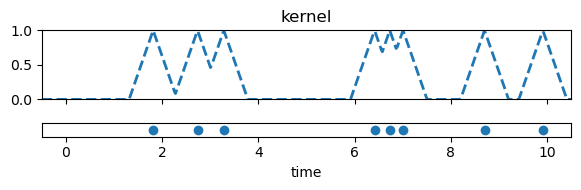

In [7]:
fig, axes = plt.subplots(2, 1, figsize=(6, 2), sharex=True, height_ratios=[1, 0.2])

times = np.linspace(-0.5, 10.5, 500)

axes[0].plot(times, kernel(f_times, times), color='C0', linestyle='--', linewidth=2)
axes[0].set_title('kernel')
axes[0].set_ylim(0, 1)

axes[1].scatter(f_times, np.zeros_like(f_times), c='C0')
axes[1].set_yticks([])

axes[-1].set_xlim(-0.5, 10.5)
axes[-1].set_xlabel('time')

fig.tight_layout()
plt.show()

## The Similarity Measures

When comparing a spike train with a reference, two aspects should be considered:
- How precise the spikes are in comparison to the reference, disregarding the false negatives (i.e., missing spikes).
- How good is the recall from the reference, disregarding the false positives (i.e., spurious spikes).

These two aspects can be measured using the two following measures:
- **Precision**: The average score of the spikes in the spike train to the closest spike in the reference.
- **Recall**: The average score of the spikes in the reference to the closest spike in the spike train.

Moreover, since a global adjustment is not relevant, the best temporal adjustment of the spike train with respect to the reference should be considered.
Due to the special shape of the kernel, the best temporal adjustment can be searched over the ones that perfectly aligns one spike in the spike train with one spike in the reference.

In [8]:
# from rsnn.similarity.measure import Measure

## Single Channel Spike Train

In [9]:
period = 10.0

n_channels = 1
n_r_f_times = 5
n_f_times = n_r_f_times

r_f_times = np.sort(np.random.uniform(0.0, period, n_r_f_times))
# f_times  = [np.sort(np.random.uniform(0.0, period, n_f_times))]
f_times = np.sort(r_f_times + 0.7 + np.random.randn(*r_f_times.shape) * 1e-1)

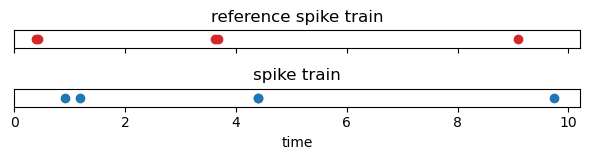

In [10]:
fig, axes = plt.subplots(2, 1, figsize=(6, 1.7), sharex=True)

axes[0].scatter(r_f_times, np.zeros_like(r_f_times), c='C3')
axes[0].set_title("reference spike train")
axes[0].set_yticks([])
# axes[0].set_xlim(0, period)

axes[1].scatter(f_times, np.zeros_like(f_times), c='C0')
axes[1].set_title("spike train")
axes[1].set_yticks([])
axes[1].set_xlim(0, None)
axes[1].set_xlabel('time')

fig.tight_layout()
plt.show()

### Precision

It measures how precise the spikes in the spike train are with respect to the reference.
The false positives (= spurious spikes) are highly detrimental to this measure.
If the spike train has no spikes, the precision is 1.0.

In [11]:
a_times = np.linspace(-period, period, 500)
precision, a_times = compute_precision([r_f_times], [f_times], a_times, 1)

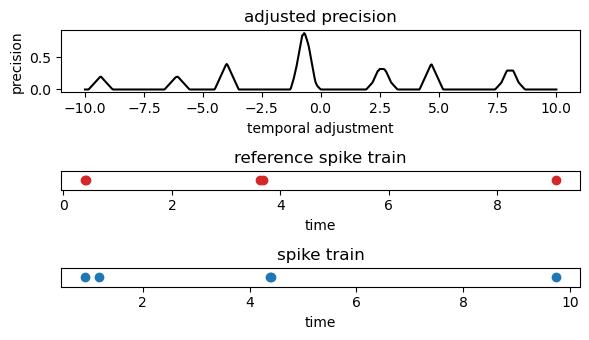

In [12]:
fig, axes = plt.subplots(3, 1, figsize=(6, 3.5), height_ratios=[1, 0.3, 0.3])

axes[0].plot(a_times, precision, color='k')

axes[0].set_title('adjusted precision')
axes[0].set_xlabel('temporal adjustment')
axes[0].set_ylabel('precision')
# axes[0].set_xlim(-period, period)

axes[1].scatter(r_f_times, np.zeros_like(r_f_times), c='C3')
axes[1].set_xlabel('time')
axes[1].set_title('reference spike train')
axes[1].set_yticks([])
# axes[1].set_xlim(0, period)

axes[2].scatter(f_times, np.zeros_like(f_times), c='C0')
axes[2].set_xlabel('time')
axes[2].set_title('spike train')
axes[2].set_yticks([])
# axes[2].set_xlim(0, period)

fig.tight_layout()
plt.show()

In [13]:
best_precision, best_alignment = compute_best_precision([r_f_times], [f_times], 1)
print(f'The best temporal adjustment of the given spikes with the reference ones is {best_alignment:.3f}, resulting in a precision of {best_precision:.3f}.')

The best temporal adjustment of the given spikes with the reference ones is -0.710, resulting in a precision of 0.876.


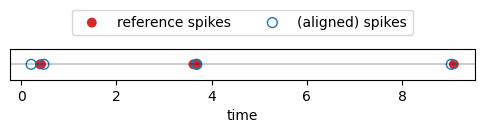

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(6, 0.4))

ax.axhline(0, color='k', alpha=0.2) 
ax.scatter(r_f_times, np.zeros_like(r_f_times), facecolors='C3', edgecolors='none', s=50, label='reference spikes')
ax.scatter(f_times + best_alignment, np.zeros_like(f_times), facecolors='none', edgecolors='C0', s=50, label='(aligned) spikes')

ax.set_xlabel('time')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 2.5), ncol=2)
ax.set_yticks([])
# ax.set_xlim(0, period)

plt.show()

### Recall

It measures how well the spikes in the reference are recalled by the spike train.
The false negatives (= missing spikes) are highly detrimental to this measure.
If the reference spike train has no spikes, the recall is 1.0.

In [15]:
a_times = np.linspace(-period, period, 500)
recall, a_times = compute_recall([r_f_times], [f_times], a_times, 1)

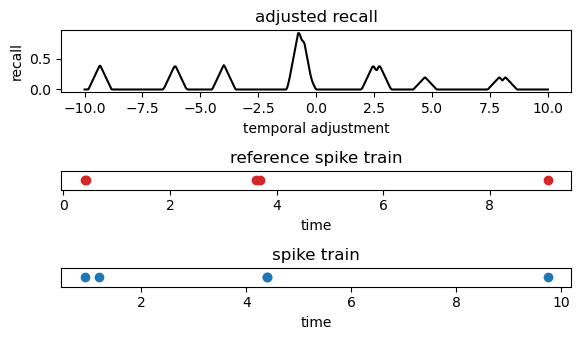

In [16]:
fig, axes = plt.subplots(3, 1, figsize=(6, 3.5), height_ratios=[1, 0.3, 0.3])

axes[0].plot(a_times, recall, color='k')

axes[0].set_title('adjusted recall')
axes[0].set_xlabel('temporal adjustment')
axes[0].set_ylabel('recall')
# axes[0].set_xlim(-period, period)

axes[1].scatter(r_f_times, np.zeros_like(r_f_times), c='C3')
axes[1].set_xlabel('time')
axes[1].set_title('reference spike train')
axes[1].set_yticks([])
# axes[1].set_xlim(0, period)

axes[2].scatter(f_times, np.zeros_like(f_times), c='C0')
axes[2].set_xlabel('time')
axes[2].set_title('spike train')
axes[2].set_yticks([])
# axes[2].set_xlim(0, period)

fig.tight_layout()
plt.show()

In [19]:
best_recall, best_alignment = compute_best_recall([r_f_times], [f_times], 1)
print(f'The best temporal adjustment of the given spikes with the reference ones is {best_alignment:.3f}, resulting in a recall of {best_recall:.3f}.')

The best temporal adjustment of the given spikes with the reference ones is -0.770, resulting in a recall of 0.925.


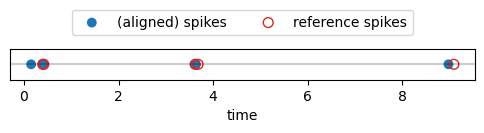

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(6, 0.4))

ax.axhline(0, color='k', alpha=0.2) 
ax.scatter(f_times + best_alignment, np.zeros_like(f_times), facecolors='C0', edgecolors='none', s=50, label='(aligned) spikes')
ax.scatter(r_f_times, np.zeros_like(r_f_times), facecolors='none', edgecolors='C3', s=50, label='reference spikes')

ax.set_xlabel('time')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 2.5), ncol=2)
ax.set_yticks([])

plt.show()

## Multichannel Similarity Measure

Average the precision and recall over all channels.
Global adjustment is determined according to the average.

In [94]:
np.random.seed(42)  # For reproducibility

period = 10.0
n_channels = 3

n_r_f_times = np.random.randint(0, 20, n_channels)
r_f_times = [np.random.uniform(0.0, period, n) for n in n_r_f_times]
measure = Measure(r_f_times, period)

# n_f_times = np.random.randint(0, 10, n_channels)
# f_times = [np.random.uniform(0.0, period, n) for n in n_f_times]
f_times = [(r_f_times_n + 0.7 + np.random.randn(r_f_times_n.size) * 5e-2) % period for r_f_times_n in r_f_times]

# n_f_times = np.copy(n_r_f_times)
# f_times = [r_f_times_c + np.random.randn(n_r_f_times_c) * 5e-2 for r_f_times_c, n_r_f_times_c in zip(r_f_times, n_r_f_times)]

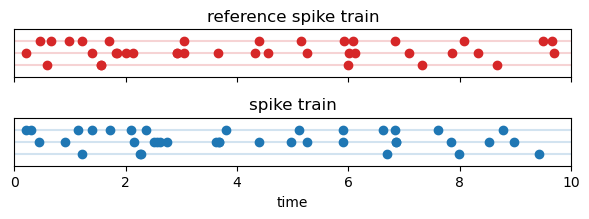

In [95]:

fig, axes = plt.subplots(2, 1, figsize=(6, 2.3), sharex=True)

for c, (r_f_times_c, f_times_c) in enumerate(zip(r_f_times, f_times)):
    axes[0].axhline(c, color='C3', alpha=0.2)
    axes[0].scatter(r_f_times_c, np.full_like(r_f_times_c, c), c='C3')
    
    axes[1].axhline(c, color='C0', alpha=0.2)
    axes[1].scatter(f_times_c, np.full_like(f_times_c, c), c='C0')

axes[0].set_title("reference spike train")
axes[0].set_yticks([])
axes[0].set_xlim(0, period)
axes[0].set_ylim(-1, n_channels)

axes[1].set_title("spike train")
axes[1].set_yticks([])
axes[1].set_xlim(0, period)
axes[1].set_ylim(-1, n_channels)
axes[1].set_xlabel('time')

fig.tight_layout()
plt.show()

### Precision

In [96]:
adjustment = np.linspace(-period/2, period/2, 500)
precision, adjustment = measure.precision(f_times, adjustment)

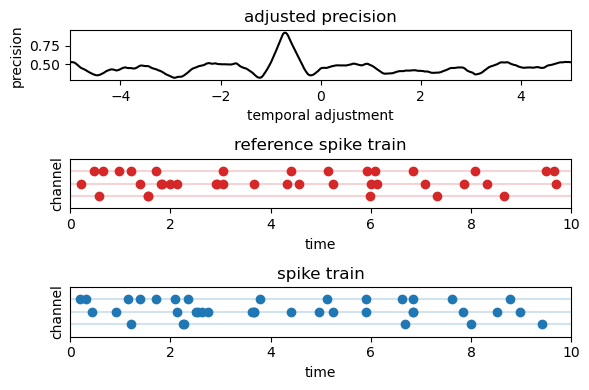

In [97]:
fig, axes = plt.subplots(3, 1, figsize=(6, 4), height_ratios=[1, 1, 1])

axes[0].plot(adjustment, precision, color='k')
axes[0].set_title('adjusted precision')
axes[0].set_xlabel('temporal adjustment')
axes[0].set_ylabel('precision')
axes[0].set_xlim(-period/2, period/2)

for c, (r_f_times_c, f_times_c) in enumerate(zip(r_f_times, f_times)):
    axes[1].axhline(c, color='C3', alpha=0.2)
    axes[1].scatter(r_f_times_c, np.full_like(r_f_times_c, c), c='C3')
    
axes[1].set_title("reference spike train")
axes[1].set_xlabel('time')
axes[1].set_ylabel('channel')
axes[1].set_yticks([])
axes[1].set_xlim(0, period)
axes[1].set_ylim(-1, n_channels)

for c, (r_f_times_c, f_times_c) in enumerate(zip(r_f_times, f_times)):    
    axes[2].axhline(c, color='C0', alpha=0.2)
    axes[2].scatter(f_times_c, np.full_like(f_times_c, c), c='C0')

axes[2].set_title("spike train")
axes[2].set_xlabel('time')
axes[2].set_ylabel('channel')
axes[2].set_yticks([])
axes[2].set_xlim(0, period)
axes[2].set_ylim(-1, n_channels)

fig.tight_layout()
plt.show()

In [98]:
precision, adjustment = measure.best_precision(f_times)
print(f'The best temporal adjustment of the given spikes with the reference ones is {adjustment:.3f}, resulting in a precision of {precision:.3f}.')

The best temporal adjustment of the given spikes with the reference ones is -0.715, resulting in a precision of 0.927.


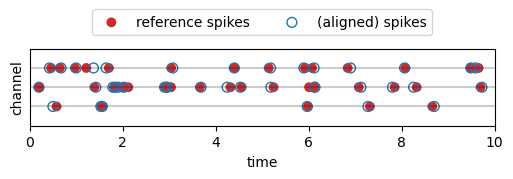

In [99]:
fig, ax = plt.subplots(1, 1, figsize=(6, 1))

ax.set_xlabel('time')
ax.set_ylabel('channel')

for c, (r_f_times_c, f_times_c) in enumerate(zip(r_f_times, f_times)):
    ax.scatter(r_f_times_c, np.full_like(r_f_times_c, c), facecolors='C3', edgecolors='none', s=50, label='reference spikes' if c==0 else None)

for c, (r_f_times_c, f_times_c) in enumerate(zip(r_f_times, f_times)):   
    ax.axhline(c, color='k', alpha=0.2) 
    ax.scatter((f_times_c + adjustment) % period, np.full_like(f_times_c, c), facecolors='none', edgecolors='C0', s=50, label='(aligned) spikes' if c==0 else None)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.6), ncol=2)
ax.set_yticks([])
ax.set_ylim(-1, n_channels)
ax.set_xlim(0, period)


plt.show()

### Recall

In [100]:
adjustment = np.linspace(-period/2, period/2, 500)
recall, adjustment = measure.recall(f_times, adjustment)

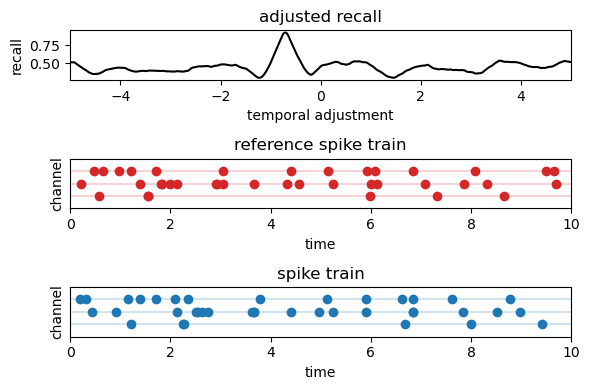

In [101]:
fig, axes = plt.subplots(3, 1, figsize=(6, 4), height_ratios=[1, 1, 1])

axes[0].plot(adjustment, recall, color='k')
axes[0].set_title('adjusted recall')
axes[0].set_xlabel('temporal adjustment')
axes[0].set_ylabel('recall')
axes[0].set_xlim(-period/2, period/2)

for c, (r_f_times_c, f_times_c) in enumerate(zip(r_f_times, f_times)):
    axes[1].axhline(c, color='C3', alpha=0.2)
    axes[1].scatter(r_f_times_c, np.full_like(r_f_times_c, c), c='C3')
    
axes[1].set_title("reference spike train")
axes[1].set_xlabel('time')
axes[1].set_ylabel('channel')
axes[1].set_yticks([])
axes[1].set_xlim(0, period)
axes[1].set_ylim(-1, n_channels)

for c, (r_f_times_c, f_times_c) in enumerate(zip(r_f_times, f_times)):    
    axes[2].axhline(c, color='C0', alpha=0.2)
    axes[2].scatter(f_times_c, np.full_like(f_times_c, c), c='C0')

axes[2].set_title("spike train")
axes[2].set_xlabel('time')
axes[2].set_ylabel('channel')
axes[2].set_yticks([])
axes[2].set_xlim(0, period)
axes[2].set_ylim(-1, n_channels)

fig.tight_layout()
plt.show()

In [102]:
recall, adjustment = measure.best_recall(f_times)
print(f'The best temporal adjustment of the given spikes with the reference ones is {adjustment:.3f}, resulting in a recall of {recall:.3f}.')

The best temporal adjustment of the given spikes with the reference ones is -0.717, resulting in a recall of 0.924.


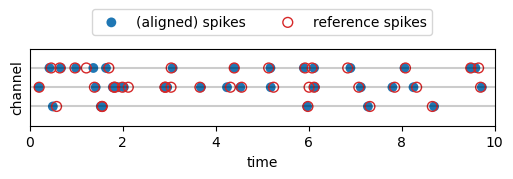

In [103]:
fig, ax = plt.subplots(1, 1, figsize=(6, 1))

ax.set_xlabel('time')
ax.set_ylabel('channel')

for c, (r_f_times_c, f_times_c) in enumerate(zip(r_f_times, f_times)):   
    ax.axhline(c, color='k', alpha=0.2) 
    ax.scatter((f_times_c + adjustment) % period, np.full_like(f_times_c, c), facecolors='C0', edgecolors='none', s=50, label='(aligned) spikes' if c==0 else None)

for c, (r_f_times_c, f_times_c) in enumerate(zip(r_f_times, f_times)):
    ax.scatter(r_f_times_c, np.full_like(r_f_times_c, c), facecolors='none', edgecolors='C3', s=50, label='reference spikes' if c==0 else None)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.6), ncol=2)
ax.set_yticks([])
ax.set_ylim(-1, n_channels)
ax.set_xlim(0, period)

plt.show()

# Performant Implementation

How to exploit sparsity in the score?
1. Work with sorted arrays for binary search.
2. The score array has dimension (n_adjustment), we can fill it sequentially.
3. Use binary search to determine the ranges of time differences that are within the kernel. For every time difference, we have the list of indices in adjustment where this time difference is within the kernel.
4. Use np.average with weights the number of spikes in the spike train and the reference.

The algorithm consists of the following steps:
1. Sort the adjustment array. All adjustments are within -period/2 and period/2.
2. For every channel, compute the time difference array, shape (n_r_f_times, n_f_times). Initialize the score array with zeros, shape (n_adjustment,). Using binary search, for each time difference, find the indices (left and right) in the adjustment array where the time difference is eps-close to the adjustment, i.e., dt - eps <= adjustment <= dt + eps (eps is the kernel half-width, e.g., 0.5). Perform the following reduction to update the score array:
    - Precision: min reduction over the r_f_times and sum over the f_times. Then divide by n_f_times.
    - Recall: min reduction over the f_times and sum over the r_f_times. Then divide by n_r_f_times.

In [31]:
np.random.seed(42)  # For reproducibility

period = 10.0

n_r_f_times = 3
r_f_times = np.sort(np.random.uniform(0.0, period, n_r_f_times))

n_f_times = 4
f_times = np.sort(np.random.uniform(0.0, period, n_f_times))

In [32]:
x = np.random.randn(3 ,4)
for x_ in x:
    print(x_)

[ 0.27904129  1.01051528 -0.58087813 -0.52516981]
[-0.57138017 -0.92408284 -2.61254901  0.95036968]
[ 0.81644508 -1.523876   -0.42804606 -0.74240684]


In [33]:
# First version ran in around 6.5 seconds.
# The best temporal adjustment for precision is -15.140, resulting in a precision of 0.154780.
# The best temporal adjustment for recall is -13.095, resulting in a precision of 0.138089.

np.random.seed(42)  # For reproducibility

period = 100.0
n_channels = 100

n_r_f_times = np.random.randint(0, 50, n_channels)
r_f_times = [np.random.uniform(0.0, period, n) for n in n_r_f_times]

n_f_times = np.random.randint(0, 50, n_channels)
f_times = [np.random.uniform(0.0, period, n) for n in n_f_times]

precision, adjustment = compute_score(f_times, r_f_times, period)
iprmax = np.argmax(precision)

print(
    f"The best temporal adjustment for precision is {adjustment[iprmax]:.3f}, resulting in a precision of {precision[iprmax]:.6f}."
)

recall, adjustment = compute_score(r_f_times, f_times, period)
ircmax = np.argmax(recall)
print(
    f"The best temporal adjustment for recall is {adjustment[ircmax]:.3f}, resulting in a precision of {recall[ircmax]:.6f}."
)

NameError: name 'compute_score' is not defined

In [ ]:
def compute_score(f_times, r_f_times, period):
    adjustment = np.unique(modulo_with_offset(np.concatenate([(r_f_times_c[None, :] - f_times_c[:, None]).reshape(-1) for f_times_c, r_f_times_c in zip(f_times, r_f_times)]), period, -period/2))
    score = np.zeros_like(adjustment)
    
    n_channels = len(f_times)

    for (f_times_c, r_f_times_c) in zip(f_times, r_f_times):
        if f_times_c.size == 0 and r_f_times_c.size == 0:
            score += np.ones_like(adjustment)
            continue
        elif f_times_c.size == 0:
            score += np.ones_like(adjustment)
            continue
        elif r_f_times_c.size == 0:
            score += np.zeros_like(adjustment)
            continue

        delta = np.concatenate(
            (
                modulo_with_offset(r_f_times_c[None, :] - f_times_c[:, None], period, -period),
                modulo_with_offset(r_f_times_c[None, :] - f_times_c[:, None], period, 0.0),
            )
        )

        for delta_n in delta:
            delta_n.sort()
            right_ids = np.clip(
                np.searchsorted(delta_n, adjustment, side="left"), 1, delta_n.size - 1
            )
            left_ids = right_ids - 1
            score += (
                1
                - 2
                * np.clip(
                    np.minimum(
                        np.abs(delta_n[left_ids] - adjustment),
                        np.abs(delta_n[right_ids] - adjustment),
                    ),
                    0.0,
                    0.5,
                )
            ) / f_times_c.size

    return score / n_channels, adjustment

In [ ]:
delta = np.concatenate(
    (modulo_with_offset(r_f_times[:, None] - f_times[None, :], period, -period),
    modulo_with_offset(r_f_times[:, None] - f_times[None, :], period, 0.0),
))

adjustment = np.unique(
    modulo_with_offset(r_f_times[:, None] - f_times[None, :], period, -period/2)
)

precision = np.zeros_like(adjustment)
for n in range(n_f_times):
    delta_n = np.sort(delta[:, n])
    right_ids = np.clip(
        np.searchsorted(delta_n, adjustment, side="left"), 1, delta_n.size - 1
    )
    left_ids = right_ids - 1
    precision += (
        1
        - 2
        * np.clip(
            np.minimum(
                np.abs(delta_n[left_ids] - adjustment),
                np.abs(delta_n[right_ids] - adjustment),
            ),
            0.0,
            0.5,
        )
    ) / n_f_times

recall = np.zeros_like(adjustment)
for n in range(n_r_f_times):
    delta_n = np.sort(delta[n, :])
    right_ids = np.clip(
        np.searchsorted(delta_n, adjustment, side="left"), 1, delta_n.size - 1
    )
    left_ids = right_ids - 1
    recall += (
        1
        - 2
        * np.clip(
            np.minimum(
                np.abs(delta_n[left_ids] - adjustment),
                np.abs(delta_n[right_ids] - adjustment),
            ),
            0.0,
            0.5,
        )
    ) / n_r_f_times

# for n in range(n_r_f_times):
#     right_ids = np.clip(
#         np.searchsorted(delta[n], adjustment, side="left"), 1, delta.shape[1] - 1
#     )
#     left_ids = right_ids - 1
#     precision += (
#         1
#         - 2
#         * np.clip(
#             np.minimum(
#                 np.abs(delta[n, left_ids] - adjustment),
#                 np.abs(delta[n, right_ids] - adjustment),
#             ),
#             0.0,
#             0.5,
#         )
#     ) / n_f_times

print(f"precision: {precision}")
print(f"recall: {recall}")

TypeError: list indices must be integers or slices, not tuple

In [ ]:
score, adjustment = compute_score(f_times, r_f_times, period)
ids = np.argsort(adjustment)
precision = score[ids]

score, adjustment = compute_score(r_f_times, f_times, period)
ids = np.argsort(-adjustment)
recall = score[ids]

precision, recall

(array([0.4998794 , 0.4998794 , 0.25      , 0.56173909, 0.65580924,
        0.65568864, 0.25      , 0.25      , 0.4998794 , 0.4998794 ,
        0.32200342, 0.32200342]),
 array([0.33333333, 0.33333333, 0.33333333, 0.54123979, 0.54123979,
        0.54107899, 0.33333333, 0.33333333, 0.33333333, 0.33333333,
        0.4293379 , 0.4293379 ]))

In [ ]:
adjustment = np.unique(modulo_with_offset(r_f_times[:, None] - f_times[None, :], period, -period/2))
precision = np.mean(kernel(f_times[None, :, None] + adjustment[:, None, None], r_f_times[None, None, :], period, axis=2), axis=1).squeeze()
recall = np.mean(kernel(f_times[None, :, None] + adjustment[:, None, None], r_f_times[None, None, :], period, axis=1), axis=1).squeeze()
precision, recall

(array([0.4998794 , 0.4998794 , 0.25      , 0.56173909, 0.65580924,
        0.65568864, 0.25      , 0.25      , 0.4998794 , 0.4998794 ,
        0.32200342, 0.32200342]),
 array([0.33333333, 0.33333333, 0.33333333, 0.54123979, 0.54123979,
        0.54107899, 0.33333333, 0.33333333, 0.33333333, 0.33333333,
        0.4293379 , 0.4293379 ]))

In [ ]:
delta = np.concatenate(
    (modulo_with_offset(r_f_times[:, None] - f_times[None, :], period, -period),
    modulo_with_offset(r_f_times[:, None] - f_times[None, :], period, 0.0),
))
# adjustment = np.unique(modulo_with_offset(r_f_times[:, None] - f_times[None, :], period, -period/2))
adjustment = np.unique(modulo_with_offset(r_f_times[:, None] - f_times[None, :], period))
scores = np.zeros_like(adjustment)
print(f'r_f_times: {r_f_times}')
print(f'adjustment: {adjustment}')

for n in range(n_f_times):
    delta[:, n].sort()
    print(f'{n}th spike at {f_times[n]:.3f}')
    print(f'delta_n: {delta[:, n]}')
    print(f'adjustment: {adjustment}')
    right_ids = np.clip(np.searchsorted(delta[:, n], adjustment, side='left'), 0, n_r_f_times - 1)
    left_ids = np.clip(right_ids - 1, 0, n_r_f_times - 1)
    print(f'left ids: {left_ids}')
    print(f'right ids: {right_ids}')
    print(f'time diff with left ids: {delta[left_ids, n]}')
    print(f'time diff with right ids: {delta[right_ids, n]}')
    scores += (1 - 2 * np.clip(np.minimum(np.abs(delta[left_ids, n] - adjustment), np.abs(delta[right_ids, n] - adjustment)), 0.0, 0.5)) / n_f_times
    print()

print(f'scores: {scores}')

r_f_times: [3.74540119 7.31993942 9.50714306]
adjustment: [-4.24024699 -4.24000579 -3.2608967  -2.24118365 -2.05304334 -2.05280214
 -1.07369306  1.33335458  2.18521478  2.18545599  3.16456507  3.52055822]
0th spike at 0.581
delta_n: [-6.83543493 -3.2608967  -1.07369306  3.16456507  6.7391033   8.92630694]
adjustment: [-4.24024699 -4.24000579 -3.2608967  -2.24118365 -2.05304334 -2.05280214
 -1.07369306  1.33335458  2.18521478  2.18545599  3.16456507  3.52055822]
left ids: [0 0 0 1 1 1 1 2 2 2 3 3]
right ids: [1 1 1 2 2 2 2 3 3 3 4 4]
time diff with left ids: [-6.83543493 -6.83543493 -6.83543493 -3.2608967  -3.2608967  -3.2608967
 -3.2608967  -1.07369306 -1.07369306 -1.07369306  3.16456507  3.16456507]
time diff with right ids: [-3.2608967  -3.2608967  -3.2608967  -1.07369306 -1.07369306 -1.07369306
 -1.07369306  3.16456507  3.16456507  3.16456507  6.7391033   6.7391033 ], 

1th spike at 1.560
delta_n: [-7.81454401 -4.24000579 -2.05280214  2.18545599  5.75999421  7.94719786]
adjustment: 

In [ ]:
adjustment = np.unique(modulo_with_offset(r_f_times[:, None] - f_times[None, :], period, -period/2))
gt_scores = np.mean(kernel(f_times[None, :, None] + adjustment[:, None, None], r_f_times[None, None, :], period, axis=2), axis=1).squeeze()
gt_scores

array([0.4998794 , 0.4998794 , 0.25      , 0.56173909, 0.65580924,
       0.65568864, 0.25      , 0.25      , 0.4998794 , 0.4998794 ,
       0.32200342, 0.32200342])

In [ ]:
# np.random.seed(42)  # For reproducibility

period = 100.0
n_channels = 100

n_r_f_times = np.random.randint(0, 30, n_channels)
r_f_times = [np.random.uniform(0.0, period, n) for n in n_r_f_times]

n_f_times = np.random.randint(0, 30, n_channels)
f_times = [np.random.uniform(0.0, period, n) for n in n_f_times]

In [ ]:
adjustment = np.unique(
    np.concatenate(
        [
            (r_f_times_c[None, :] - f_times_c[:, None]).reshape(-1)
            for f_times_c, r_f_times_c in zip(f_times, r_f_times)
        ]
    )
)

precision = np.mean(
    [
        (
            np.mean(
                kernel(
                    f_times_c[None, :, None] + adjustment[:, None, None],
                    r_f_times_c[None, None, :],
                    period,
                    axis=2,
                ),
                axis=1,
            ).squeeze()
            if f_times_c.size > 0 and r_f_times_c.size > 0
            else (
                np.ones_like(adjustment)
                if f_times_c.size == 0
                else np.zeros_like(adjustment)
            )
        )
        for f_times_c, r_f_times_c in zip(f_times, r_f_times)
    ],
    axis=0,
)
iprmax = np.argmax(precision)
print(
    f"The best temporal adjustment for precision is {adjustment[iprmax]:.3f}, resulting in a precision of {precision[iprmax]:.6f}."
)

recall = np.mean(
    [
        (
            np.mean(
                kernel(
                    f_times_c[None, :, None] + adjustment[:, None, None],
                    r_f_times_c[None, None, :],
                    period,
                    axis=1,
                ),
                axis=1,
            ).squeeze()
            if f_times_c.size > 0 and r_f_times_c.size > 0
            else (
                np.ones_like(adjustment)
                if r_f_times_c.size == 0
                else np.zeros_like(adjustment)
            )
        )
        for f_times_c, r_f_times_c in zip(f_times, r_f_times)
    ],
    axis=0,
)
ircmax = np.argmax(recall)
print(
    f"The best temporal adjustment for recall is {adjustment[ircmax]:.3f}, resulting in a recall of {recall[ircmax]:.6f}."
)

The best temporal adjustment for precision is -58.463, resulting in a precision of 0.111615.
The best temporal adjustment for recall is 19.482, resulting in a recall of 0.117521.


In [ ]:
np.random.seed(42)  # For reproducibility

period = 100.0
n_channels = 100

n_r_f_times = np.random.randint(0, 30, n_channels)
r_f_times = [np.random.uniform(0.0, period, n) for n in n_r_f_times]

n_f_times = np.random.randint(0, 30, n_channels)
f_times = [np.random.uniform(0.0, period, n) for n in n_f_times]

precision, adjustment = compute_score(f_times, r_f_times, period)
iprmax = np.argmax(precision)

print(
    f"The best temporal adjustment for precision is {adjustment[iprmax]:.3f}, resulting in a precision of {precision[iprmax]:.6f}."
)

recall, adjustment = compute_score(r_f_times, f_times, period)
ircmax = np.argmax(recall)
print(
    f"The best temporal adjustment for recall is {adjustment[ircmax]:.3f}, resulting in a precision of {recall[ircmax]:.6f}."
)

The best temporal adjustment for precision is 41.537, resulting in a precision of 0.111615.
The best temporal adjustment for recall is -19.482, resulting in a precision of 0.117521.


In [ ]:
adjustment.size

9095

In [ ]:
adjustment = np.unique(np.concatenate([(r_f_times_c[None, :] - f_times_c[:, None]).reshape(-1) for f_times_c, r_f_times_c in zip(f_times, r_f_times)]))
precisions = np.mean([np.sum(kernel(f_times_c[None, :, None] + adjustment[:, None, None], r_f_times_c[None, None, :], period, axis=2), axis=1).squeeze() / n_f_times_c for f_times_c, r_f_times_c, n_f_times_c in zip(f_times, r_f_times, n_f_times)], axis=0)


In [ ]:
def kernel_v2(times, rf_times, period):
    """
    Compute the kernel function for a given set of times and reference spike times.
    """
    # dist = cyclic_distance(f_times[:,None], times[None, :], period)
    # return 2 * np.min(dist, axis=0).clip(max=0.5) # dissimilarity measure
    return 1.0 - 2 * cyclic_distance(rf_times, times, period).clip(
        max=0.5
    )  # similarity measure

In [ ]:
c = 10
adjustment = np.unique(np.concatenate([(r_f_times_c[None, :] - f_times_c[:, None]).reshape(-1) for f_times_c, r_f_times_c in zip(f_times, r_f_times)]))
res = kernel_v2(f_times[c][None, :, None] + adjustment[:, None, None], r_f_times[c][None, None, :], period)
print(f'c: {c}')
print(f'n_f_times: {n_f_times[c]}')
print(f'n_r_f_times: {n_r_f_times[c]}')
print(f'res sparsity: {np.sum(res == 0) / res.size}')
print(f'res.shape: {res.shape}')

c: 10
n_f_times: 1
n_r_f_times: 7
res sparsity: 0.9898520021925601
res.shape: (9643, 1, 7)


In [ ]:
def is_sorted(arr, axis=0):
    """
    Check if the array is sorted along the specified axis.
    """
    return np.all(np.diff(arr, axis=axis) >= 0)

In [ ]:
period = 10.0
f_times = np.sort(np.random.uniform(0.0, period, 3))
r_f_times = np.sort(np.random.uniform(0.0, period, 4))

In [ ]:
adjustment = r_f_times[:,None] - f_times[None,:]
print(f'sorted in the dim 1: {is_sorted(adjustment, 0)}') # increasing order in the first dimension
print(f'sorted in the dim 2: {is_sorted(-adjustment, 1)}') # decreasing order in the second dimension

sorted in the dim 1: True
sorted in the dim 2: True


In [ ]:
adj_f_times = f_times[:, None, None] + adjustment[None, :, :]
print(f'sorted in the dim 1: {is_sorted(adj_f_times, 0)}') # increasing order in the first dimension
print(f'sorted in the dim 2: {is_sorted(adj_f_times, 1)}') # increasing order in the second dimension
print(f'sorted in the dim 3: {is_sorted(-adj_f_times, 2)}') # decreasing order in the third dimension


sorted in the dim 1: True
sorted in the dim 2: True
sorted in the dim 3: True


In [ ]:
scores = adj_f_times[:, None, :, :] - r_f_times[None, :, None, None]
print(f'sorted in the dim 1: {is_sorted(scores, 0)}') # increasing order in the first dimension
print(f'sorted in the dim 2: {is_sorted(-scores, 1)}') # decreasing order in the second dimension
print(f'sorted in the dim 3: {is_sorted(scores, 2)}') # increasing order in the third dimension
print(f'sorted in the dim 4: {is_sorted(-scores, 3)}') # decreasing order in the fourth dimension


sorted in the dim 1: True
sorted in the dim 2: True
sorted in the dim 3: True
sorted in the dim 4: True


In [ ]:
period = 10.0
f_times = np.sort(np.random.uniform(0.0, period, 3))
r_f_times = np.sort(np.random.uniform(0.0, period, 4))

In [ ]:
adjustment = np.unique(modulo_with_offset(r_f_times[:,None] - f_times[None,:], period, -period/2))
adjustment

array([-4.27743421, -4.25806221, -3.73520441, -2.35454673, -2.00584371,
       -2.00356817, -1.46133837, -0.10005269,  0.26802234,  0.44217711,
        2.17153781,  3.46807175])

In [ ]:
print(f'f_times: {f_times}')
print(f'r_f_times: {r_f_times}')

f_times: [0.4475015  6.27011998 8.17363546]
r_f_times: [3.91557326 6.1700673  6.71229709 8.4416578 ]


In [ ]:
# for precision, the reduction is done along the reference spike times (axis=0)
# each spike is compared with at most one reference spike
diff = np.concatenate((r_f_times[:, None] - f_times[None, :], r_f_times[:, None] + period - f_times[None, :]))
# diff.sort(axis=0)
diff.shape

(8, 3)

In [ ]:
is_sorted(adjustment, 0)

np.True_

In [ ]:
id_left = np.clip(np.searchsorted(adjustment, diff - 0.5, side='left'), 0, adjustment.size - 1)
id_right = np.clip(np.searchsorted(adjustment, diff + 0.5, side='right'), 1 , adjustment.size)
(adjustment[id_right] - diff).shape

(8, 3)

In [ ]:
scores = np.zeros_like(adjustment)


In [ ]:

part_score_1 = np.min(np.abs(adjustment[id_right] - diff), axis=0).clip(max=0.5)
part_score_2 = np.abs(adjustment[id_right - 1] - diff).clip(max=0.5)
select = part_score_1 < part_score_2
scores[select] += part_score_1
scores[~select] += part_score_2

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
adjustment[id_right - 1] - diff

array([[-1.29653394e+00, -1.38065768e+00, -1.93719998e-02],
       [-3.55102798e+00, -1.36128568e+00, -2.27554049e-03],
       [-4.09325777e+00, -1.74154772e-01, -5.42229795e-01],
       [-5.82261848e+00, -1.72936071e+00, -3.68075022e-01],
       [-1.12965339e+01, -5.47391546e+00, -3.57039998e+00],
       [-1.35510280e+01, -7.72840950e+00, -5.82489402e+00],
       [-1.40932578e+01, -8.27063929e+00, -6.36712382e+00],
       [-1.58226185e+01, -1.00000000e+01, -8.09648452e+00]])

In [ ]:
for t, rt in np.meshgrid(f_times, r_f_times):
    print(f't: {t}, rt: {rt}')

ValueError: too many values to unpack (expected 2)

In [ ]:
adjustment[id_left[1]]

array([ 3.46807175, -0.10005269, -2.35454673])

In [ ]:
adjustment[id_left] - diff

array([[  0.        ,   0.        ,  -0.019372  ],
       [ -2.25449404,   0.        ,  -0.35097856],
       [ -2.79672384,  -0.17415477,   0.        ],
       [ -4.52608454,   0.        ,  -0.36807502],
       [-10.        ,  -4.17738152,  -2.27386604],
       [-12.25449404,  -6.43187556,  -4.52836008],
       [-12.79672384,  -6.97410536,  -5.07058988],
       [-14.52608454,  -8.70346606,  -6.79995058]])

In [ ]:
adjustment[id_right-1] - diff

array([[  0.        ,   0.35097856,   0.        ],
       [ -2.25449404,   0.36807502,   0.        ],
       [ -2.79672384,   0.        ,   0.        ],
       [ -4.52608454,   0.        ,   0.17415477],
       [-10.        ,  -4.17738152,  -2.27386604],
       [-12.25449404,  -6.43187556,  -4.52836008],
       [-12.79672384,  -6.97410536,  -5.07058988],
       [-14.52608454,  -8.70346606,  -6.79995058]])

In [ ]:
for (il, ir) in zip(id_left, id_right):
    print(il, ir)

[11  3  0] [12  6  2]
[11  7  3] [12  9  6]
[11  8  6] [12 10  7]
[11 10  7] [12 11 10]
[11 11 11] [12 12 12]
[11 11 11] [12 12 12]
[11 11 11] [12 12 12]
[11 11 11] [12 12 12]


In [23]:
period = np.inf 
r_f_times = np.random.uniform(0, 10.0, 5)
f_times = np.random.uniform(0, 10.0, 5)

(r_f_times[None, :] - f_times[:, None]) % period

array([[7.52286892, 1.08136583, 5.15630528, 8.75537264, 5.33035082],
       [2.74897698,        inf, 0.38241335, 3.9814807 , 0.55645889],
       [3.61967673,        inf, 1.25311309, 4.85218045, 1.42715863],
       [0.8957018 ,        inf,        inf, 2.12820552,        inf],
       [2.35604043,        inf,        inf, 3.58854415, 0.16352233]])

In [48]:
def kernel_v1(times, f_times):
    """
    Assume f_times is sorted

    Args:
        t (_type_): _description_
        f_times (_type_): _description_
    """
    right_ids = np.clip(np.searchsorted(f_times, times, side='left'), 1, f_times.size - 1)
    return 1.0 - 2 * np.minimum(np.abs(f_times[right_ids] - times), np.abs(f_times[right_ids - 1] - times)).clip(max=0.5)

In [72]:
def kernel_v2(times, f_times):
    """
    Assume f_times is sorted

    Args:
        times (_type_): _description_
        f_times (_type_): _description_
    """
    return 1.0 - 2 * np.min(np.clip(np.abs(np.expand_dims(f_times,  axis=tuple(range(1, times.ndim + 1))) - times[None,...]), 0.0, 0.5), axis=0)

In [80]:
f_times = np.sort(np.random.rand(5))
times = np.random.rand(3,4)

In [81]:
kernel_v1(times, f_times)

array([[0.89182821, 0.51833528, 0.98270841, 0.4226064 ],
       [0.60046132, 0.56461467, 0.91110384, 0.86352399],
       [0.72509459, 0.6183572 , 0.97951542, 0.63522515]])

In [82]:
kernel_v2(times, f_times)

array([[0.89182821, 0.51833528, 0.98270841, 0.4226064 ],
       [0.60046132, 0.56461467, 0.91110384, 0.86352399],
       [0.72509459, 0.6183572 , 0.97951542, 0.63522515]])

In [84]:
%%timeit
times = np.random.rand(50,50)
f_times = np.sort(np.random.rand(1000))

70.8 μs ± 9.62 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [88]:
%%timeit
times = np.random.rand(50,50)
f_times = np.sort(np.random.rand(100))
kernel_v1(times, f_times)

176 μs ± 12.1 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [89]:
%%timeit
times = np.random.rand(50,50)
f_times = np.sort(np.random.rand(100))
kernel_v2(times, f_times)

799 μs ± 111 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [92]:
def precision_v1(times, f_times, r_f_times):
    return (kernel_v1(times[None, :] + f_times[:,None], r_f_times)).sum(axis=0) / f_times.size

In [93]:
def precision_v2(times, f_times, r_f_times):
    return (kernel_v2(times[None, :] + f_times[:,None], r_f_times)).sum(axis=0) / f_times.size

In [96]:
times = np.linspace(0,1,11)
f_times = np.array([0.1, 0.7])
r_f_times = f_times + 0.3

In [ ]:
%%timeit 
precision_v1(times, f_times, r_f_times)

array([0.4, 0.6, 0.8, 1. , 0.8, 0.6, 0.4, 0.4, 0.4, 0.5, 0.4])

In [99]:
%%timeit
times = np.random.rand(10000)
f_times = np.sort(np.random.rand(20))
r_f_times = np.sort(np.random.rand(20))

84.8 μs ± 12.2 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [100]:
%%timeit
times = np.random.rand(10000)
f_times = np.sort(np.random.rand(20))
r_f_times = np.sort(np.random.rand(20))
precision_v1(times, f_times, r_f_times)

4.22 ms ± 170 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [101]:
%%timeit
times = np.random.rand(10000)
f_times = np.sort(np.random.rand(20))
r_f_times = np.sort(np.random.rand(20))
precision_v2(times, f_times, r_f_times)

14.1 ms ± 1.35 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
# for periodic spike trains
# complexity is
# linear in f_times and a_times, and logarithmic in r_f_times

a_times = np.random.rand(100)
f_times = np.sort(np.random.rand(20))
r_f_times = np.sort(np.random.rand(20))

precision_v1(a_times, f_times, r_f_times)

In [103]:
from rsnn.constants import REFRACTORY_PERIOD

In [112]:
def periodic_extension(x, min_x, max_x, period):
    """
    Extend the array x periodically between min_x and max_x.
    """
    if np.isinf(period):
        return x
    else:
        return np.concatenate(
            [
                x + period * n
                for n in range(int(np.ceil((min_x - x[0]) / period)), int(np.floor((max_x - x[0]) / period)) + 1)
            ]
        )

In [ ]:
def kernel(f_times, times):
    """
    Compute the kernel function for a given set of times and sorted reference spike times.
    The complexity is linear in times, and logarithmic in f_times.

    Args:
        f_times (_type_): _description_
        times (_type_): _description_
    """
    right_ids = np.clip(
        np.searchsorted(f_times, times, side="left"), 1, f_times.size - 1
    )
    return 1.0 - 2 * np.minimum(
        np.abs(f_times[right_ids] - times), np.abs(f_times[right_ids - 1] - times)
    ).clip(max=0.5)


def compute_precision(r_f_times, f_times, a_times, n_channels):
    """
    Compute the precision of the spike train f_times with respect to the (sorted) reference spike train r_f_times.
    Complexity is linear in f_times and a_times, and logarithmic in r_f_times.

    Args:
        f_times (np.ndarray): Spike times of the spike train to evaluate.
        r_f_times (np.ndarray): Sorted reference spike times.
        a_times (np.ndarray): Array of temporal adjustments to evaluate the precision at.
        n_channels (int): Number of channels.

    Returns:
        np.ndarray: Precision values for each time adjustment in a_times.
    """

    precision = np.zeros_like(a_times)

    for f_times_c, r_f_times_c in zip(f_times, r_f_times):
        if f_times_c.size > 0:
            precision += (
                kernel(f_times_c[:, None] + a_times[None, :], r_f_times_c)
            ).sum(axis=0) / f_times_c.size

        else:
            precision += np.ones_like(a_times)

    return precision / n_channels


def compute_recall(r_f_times, f_times, a_times, n_channels):
    """
    Compute the precision of the spike train f_times with respect to the reference spike train r_f_times.

    Args:
        f_times (np.ndarray): Sorted spike times of the spike train to evaluate.
        r_f_times (np.ndarray): Sorted reference spike times.
        a_times (np.ndarray): Array of times adjustment to evaluate the precision at.

    Returns:
        np.ndarray: Recall values for each time adjustment in a_times.
    """

    recall = np.zeros_like(a_times)

    for f_times_c, r_f_times_c in zip(f_times, r_f_times):
        f_times_c.sort()
        r_f_times_c.sort()

        if r_f_times_c.size > 0:
            recall += (kernel(r_f_times[:, None] - a_times[None, :], f_times)).sum(
                axis=0
            ) / r_f_times.size

        else:
            recall += np.ones_like(a_times)

    return recall / n_channels


def compute_best_precision(r_f_times, f_times, n_channels, period=None):
    """
    Compute the best precision for given spike times.

    Args:
        f_times (list of np.ndarray): List of spike times for each channel.

    Returns:
        tuple: Best precision and corresponding adjustment.
    """
    a_times = np.concatenate(
        [
            (r_f_times_c[None, :] - f_times_c[:, None]).reshape(-1)
            for f_times_c, r_f_times_c in zip(f_times, r_f_times)
        ]
        + [np.zeros(1)]
    )

    if period is None:
        precision = compute_precision(r_f_times, f_times, a_times, n_channels)
        best_id = np.argmax(precision)
        return precision[best_id], a_times[best_id]

    else:
        a_times %= period
        ext_r_f_times = []
        for f_times_c, r_f_times_c in zip(f_times, r_f_times):
            f_times_c %= period  # a_times + f_times is between 0 and 2 * period
            r_f_times_c = np.unique(r_f_times_c % period)  # sorted!
            ext_r_f_times.append(
                np.concatenate(
                    [
                        r_f_times_c[-1] - period,
                        r_f_times_c,
                        r_f_times_c + period,
                        r_f_times_c[0] + 2 * period,
                    ]
                )
            )

        precision = compute_precision(ext_r_f_times, f_times, a_times, n_channels)
        best_id = np.argmax(precision)
        return precision[best_id], a_times[best_id]

        # np.unique(r_f_times % period)  # sorted!

        # min_r_f_times = r_f_times[0] + a_times[0] - REFRACTORY_PERIOD / 2
        # max_r_f_times = r_f_times[-1] + a_times[-1] + REFRACTORY_PERIOD / 2
        # ext_r_f_times = np.sort(
        #     r_f_times[:, None]
        #     + np.arange(
        #         np.floor_divide(min_r_f_times, period),
        #         np.floor_divide(max_r_f_times, period) + 1,
        #     )
        #     * period,
        #     axis=None,
        # )
        # ext_r_f_times = ext_r_f_times[
        #     (ext_r_f_times >= min_r_f_times) & (ext_r_f_times <= max_r_f_times)
        # ]

    # return precision(f_times, ext_r_f_times, a_times)


# def compute_best_recall(self, f_times, period):
#     """
#     Compute the best recall for given spike times.

#     Args:
#         f_times (list of np.ndarray): List of spike times for each channel.

#     Returns:
#         tuple: Best recall and corresponding adjustment.
#     """
#     return recall(
#         f_times, self.r_f_times, np.linspace(-self.period / 2, self.period / 2, 500)
#     )

In [167]:
period = 10.0
# f_times = np.random.uniform(0, period, 10)
# r_f_times = np.random.uniform(0, period, 10)
# a_times = np.linspace(-period / 2, period / 2, 10)

r_f_times = np.array([0.2, 0.7])
f_times = r_f_times + 0.3
a_times = r_f_times[:,None] - f_times[None,:]

if period <= 0:
    raise ValueError("Period must be positive.")

if np.isinf(period):
    a_times = np.sort(a_times)
    f_times = np.sort(f_times)
    r_f_times = np.sort(r_f_times)
    ext_r_f_times = np.copy(r_f_times)
else:
    a_times = np.unique(a_times)  # a_times is sorted!!
    f_times = np.unique(f_times % period)  # sorted!
    r_f_times = np.unique(r_f_times % period)  # sorted!

    min_r_f_times = r_f_times[0] + a_times[0] - REFRACTORY_PERIOD / 2
    max_r_f_times = r_f_times[-1] + a_times[-1] + REFRACTORY_PERIOD / 2
    ext_r_f_times = np.sort(
        r_f_times[:, None]
        + np.arange(
            np.floor_divide(min_r_f_times, period),
            np.floor_divide(max_r_f_times, period) + 1,
        )
        * period,
        axis=None,
    )
    ext_r_f_times = ext_r_f_times[
        (ext_r_f_times >= min_r_f_times) & (ext_r_f_times <= max_r_f_times)
    ]

precision_v1(a_times, f_times, ext_r_f_times), a_times

(array([0.5, 1. , 1. , 0.5]), array([-0.8, -0.3, -0.3,  0.2]))

In [168]:
a_times[0] + f_times[0], a_times[-1] + f_times[-1], ext_r_f_times

(np.float64(-0.30000000000000004), np.float64(1.2), array([0.2, 0.7]))

In [131]:
f_times = np.sort(np.random.uniform(0.0, 10.0, 5))
periodic_extension(f_times, 10.0, 25.0, 10.0)

array([11.75613973, 14.10182264, 14.14637764, 15.00687197, 19.30199527,
       21.75613973, 24.10182264, 24.14637764, 25.00687197, 29.30199527])